In [14]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict, Annotated, Dict
from langgraph.graph import add_messages, StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
search_tool = TavilySearchResults(max_results=2)

tools = [search_tool]

/tmp/ipykernel_31910/1399711242.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


In [5]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

llm_with_tools = llm.bind_tools(tools)

In [6]:
def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

In [7]:
def tools_router(state: ChildState):
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    else:
        return "end"

In [8]:
tool_node = ToolNode(tools=tools)

In [9]:
search_graph_builder = StateGraph(ChildState)

search_graph_builder.add_node("agent", agent)
search_graph_builder.add_node("tool_node", tool_node)

search_graph_builder.set_entry_point("agent")

search_graph_builder.add_conditional_edges(
    "agent",
    tools_router,
    {
        "tools": "tool_node",
        "end": END
    }
)

search_graph_builder.add_edge("tool_node", "agent")

search_graph = search_graph_builder.compile()

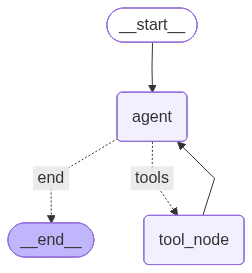

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [11]:
search_graph.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='9e9fcd41-32ba-45a8-8dcb-7b5ce68418fb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '72d76vmga', 'function': {'arguments': '{"query":"Chennai weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.059831591, 'prompt_time': 0.024425805, 'queue_time': 0.084562409, 'total_time': 0.084257396}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4bb1410c-bdb2-4d9c-9c0b-e010eee883a5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather'}, 'id': '72d76vmga', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305}),
  ToolM

Case 1: Shared Schema (Direct Embedding)

In [13]:
# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph_builder = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph_builder.add_node("search_agent", search_graph)

# Connect the flow
parent_graph_builder.add_edge(START, "search_agent")
parent_graph_builder.add_edge("search_agent", END)

# Compile parent graph
parent_graph = parent_graph_builder.compile()

# Run the parent graph
result = parent_graph.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})
result

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='a39b116f-bade-44bd-a366-10a2d30ca862'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8k1xa2h0q', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.064627983, 'prompt_time': 0.023894357, 'queue_time': 2.719450119, 'total_time': 0.08852234}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--14c7e525-29b9-4481-a53b-153b2c474bd3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': '8k1xa2h0q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306

Case 2: Different Schema (Invoke with Transformation)

In [15]:
# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

In [16]:
# You should have a Function to invoke subgraph
def invoke_search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    
    # Invoke subgraph
    subgraph_output = search_graph.invoke(subgraph_input)
    
    # Transform from subgraph schema to parent schema
    assistant_message = subgraph_output["messages"][-1]
    return {
        "response": assistant_message.content
    }

In [17]:
# Create parent graph
grandpa_graph_builder = StateGraph(QueryState)

# Add transformation node that invokes subgraph
grandpa_graph_builder.add_node("search_agent", invoke_search_agent)

# Connect the flow
grandpa_graph_builder.add_edge(START, "search_agent")
grandpa_graph_builder.add_edge("search_agent", END)

# Compile the graph
grandpa_graph = grandpa_graph_builder.compile()


In [18]:
grandpa_graph.invoke({
    "query": "How is the weather in Egypt?",
    "response": ""
})

{'query': 'How is the weather in Egypt?',
 'response': 'The current weather in Egypt is hot, with temperatures ranging from 22° to 27° in the northern coastal regions and around 32° in the southern cities. The Red Sea resorts, such as Hurghada and Sharm El Sheikh, are experiencing pleasant temperatures, averaging around 30°. There is little rainfall in the southern cities, and the weather is expected to remain hot throughout September, with average temperatures between 71°F and 96°F.'}